In [1]:
"""Library"""
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from common import (data_path, date_col, missing_code, price_col, projectpath,
                    symbol_col, train_percent, valid_percent)
from sklearn.linear_model import LinearRegression

# load data
select = "factor"
data = pd.read_csv(data_path[select])
data[date_col] = pd.to_datetime(data[date_col])
data = data.set_index([symbol_col, date_col])\
    .replace(missing_code, float("NaN"))\
    .dropna(axis=0)\
    .astype("float")

# keep only fama french factors
data = data[[price_col, "hml", "rf", "rm", "rmrf", "smb", "umd"]]

data.head()

/home/ling/miniconda3/envs/ap_tf2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/ling/miniconda3/envs/ap_tf2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


excess_returns       hml        rf        rm      rmrf  \
symbol date                                                                 
3IN    2008-04-30        0.071916  0.009833  0.003991  0.062580  0.058589   
       2008-05-31        0.022298 -0.029344  0.004108 -0.001998 -0.006106   
       2008-06-30       -0.010799 -0.027738  0.004159 -0.070678 -0.074837   
       2008-07-31        0.002396 -0.069655  0.004134 -0.036035 -0.040168   
       2008-08-31       -0.072512 -0.001523  0.004025  0.049905  0.045881   

                        smb       umd  
symbol date                            
3IN    2008-04-30 -0.049409  0.068718  
       2008-05-31 -0.010052  0.044772  
       2008-06-30 -0.024877  0.135133  
       2008-07-31  0.016760  0.001473  
       2008-08-31 -0.006549 -0.095469

In [2]:
"""One asset"""
subset_data = data.loc["ABC"]
train_index = round(subset_data.shape[0] * train_percent)
valid_index = round(subset_data.shape[0] * valid_percent)
train_data = subset_data.iloc[:train_index, :]
valid_data = subset_data.iloc[train_index:valid_index, :]
test_data = subset_data.iloc[valid_index:, :]
mod = sm.OLS(train_data.loc[:, price_col],
             train_data.drop(columns=[price_col]).assign(const=1),
             missing=missing_code,
             hasconst=True)

res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         excess_returns   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.461
Date:                Wed, 23 Mar 2022   Prob (F-statistic):              0.202
Time:                        21:49:03   Log-Likelihood:                 59.530
No. Observations:                  90   AIC:                            -105.1
Df Residuals:                      83   BIC:                            -87.56
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hml            0.1248      0.739      0.169      0.866      -1.345       1.595
rf         -2.268e+06   5.38e+06     -0.421      0.675    -1.3e+07    8.44e+06
rm          2.268e+06   5.38e+06      0.421      0.675   -8.44e+06     1.3e+07
rmrf       -2.268e+06   5.38e+06     -0.421      0.675    -1.3e+07    8.44e+06
smb           -0.6501      0.464     -1.402      0.165      -1.572       0.272
umd           -0.7807      0.348     -2.243      0.028      -1.473      -0.088
const          0.0848      0.022      3.934      0.000       0.042       0.128
==============================================================================
Omnibus:                       48.198   Durbin-Watson:                   0.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.762
Skew:                           1.906   Prob(JB):                     5.46e-30
Kurtosis:                       7.627   Cond. No.                     6.80e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.95e-16. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [3]:
"""Sklearn Linear Regression"""
coef = {}

for symbol in data.index.get_level_values("symbol").unique():
    subset_data = data.loc[symbol]

    train_index = round(subset_data.shape[0] * train_percent)
    valid_index = round(subset_data.shape[0] * valid_percent)
    train_data = subset_data.iloc[:train_index, :]
    valid_data = subset_data.iloc[train_index:valid_index, :]
    test_data = subset_data.iloc[valid_index:, :]

    train_X = train_data.drop(columns=[price_col])
    train_y = train_data.loc[:, price_col]
    valid_X = valid_data.drop(columns=[price_col])
    valid_y = valid_data.loc[:, price_col]
    test_X = test_data.drop(columns=[price_col])
    test_y = test_data.loc[:, price_col]

    lr = LinearRegression()\
        .fit(train_X, train_y)

    valid_pred = lr.predict(valid_X)
    valid_intercept = (valid_y - valid_pred).mean()

    test_pred = lr.predict(test_X)
    test_intercept = (test_y - test_pred).mean()

    coef[symbol] = dict(zip(lr.feature_names_in_, lr.coef_))
    coef[symbol]["train_intercept"] = lr.intercept_
    coef[symbol]["valid_intercept"] = valid_intercept
    coef[symbol]["test_intercept"] = test_intercept

In [4]:
coef = pd.DataFrame(coef).T

coef

,hml,rf,rm,rmrf,smb,umd,train_intercept,valid_intercept,test_intercept
3IN,0.770881,-1.158275e+06,1.158270e+06,-1.158271e+06,-1.105687,-1.015227,0.059254,-0.033476,-0.044668
888,0.148185,6.928776e+06,-6.928788e+06,6.928789e+06,-0.877985,-0.511057,0.058498,-0.049590,-0.028366
88E,2.922272,-5.618837e+07,5.618841e+07,-5.618841e+07,-6.182664,1.939724,-0.001424,0.035705,-0.117705
AAIF,0.790991,2.816538e+06,-2.816553e+06,2.816552e+06,-1.030921,-0.847226,0.072223,-0.064155,-0.043179
AAL,0.096109,3.453144e+06,-3.453167e+06,3.453166e+06,0.012111,-0.733353,0.108398,-0.104294,-0.090606
...,...,...,...,...,...,...,...,...,...
ZIOC,0.466970,-2.169208e+07,2.169160e+07,-2.169160e+07,1.912437,0.496260,0.050431,0.190372,0.027500
ZOL,6.853139,2.513509e+07,-2.513482e+07,2.513482e+07,-0.604728,1.180591,-0.067630,-0.099296,0.018951
ZOO,-1.098622,3.124139e+06,-3.124185e+06,3.124184e+06,0.270820,-1.100419,0.145019,-0.165301,-0.066791
ZTF,0.159983,4.436799e+06,-4.436837e+06,4.436837e+06,0.170495,-0.199110,0.154796,-0.124331,-0.125153


In [5]:
coef["train_intercept"].abs().describe()

count    844.000000
mean       0.141814
std        0.128258
min        0.000732
25%        0.069636
50%        0.123302
75%        0.162761
max        1.246650
Name: train_intercept, dtype: float64

In [6]:
coef["valid_intercept"].abs().describe()

count    844.000000
mean       0.115136
std        0.099551
min        0.000019
25%        0.055602
50%        0.100573
75%        0.134641
max        0.893867
Name: valid_intercept, dtype: float64

In [7]:
coef["test_intercept"].abs().describe()

count    844.000000
mean       0.120906
std        0.084352
min        0.000778
25%        0.059501
50%        0.113790
75%        0.153475
max        0.639273
Name: test_intercept, dtype: float64

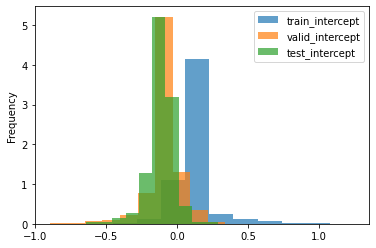

In [8]:
coef["train_intercept"].plot.hist(density=True, alpha=0.7)
coef["valid_intercept"].plot.hist(density=True, alpha=0.7)
coef["test_intercept"].plot.hist(density=True, alpha=0.7)
plt.legend()

In [9]:
# export results
coef.to_csv(f"{projectpath}/data/alpha/fama_{select}.csv")